In [1]:
# std packages
%matplotlib inline
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
font={'size':18}
axes={'linewidth':2.0, 
      'labelsize':18,
      'grid':True}
tick={'labelsize':18}
legend_s={'fontsize':14, 
          'labelspacing': 0.25,
          'handletextpad': 0.25, 
          'borderaxespad':0.25, 
          'columnspacing':0.25}
lines={'lw':2.0}
rc('font', **font)
rc('axes', **axes)
rc('xtick', **tick)
rc('ytick', **tick)
rc('legend', **legend_s)
rc('lines', **lines)

from IPython.display import Latex

# pykat
from pykat import finesse
from pykat.commands import *

                                              ..-
    PyKat 1.0.18          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [8]:
"""
Task 1: misalign a mirror outside a cavity
"""

kat=finesse.kat()
kat.loadKatFile('misalignMirror.kat')
kat.verbose=False

cmd="""
    ad E_c_00 0 0 0 n_bs2
    ad E_c_01 0 1 0 n_bs2
    ad E_c_10 1 0 0 n_bs2
    
    bp SPOT y w n_bs2

    xaxis BS ybeta lin -1u 1u 10
    yaxis re:im
    """

kat.parseCommands(cmd)
out=kat.run()
SPOT=np.real(out['SPOT'][0])
E_c_00=out['E_c_00']
E_c_01=out['E_c_01']

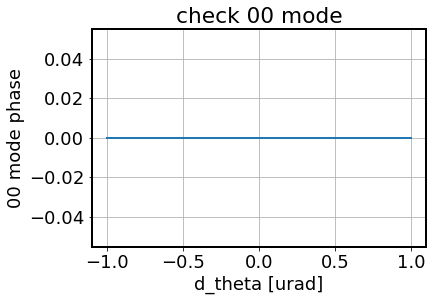

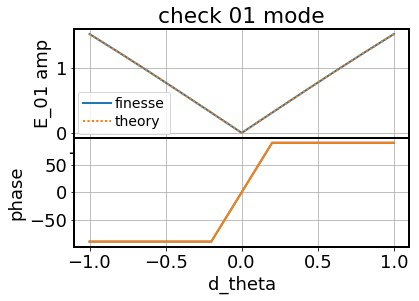

In [11]:
x=out.x
## first check 00 mode
plt.figure()
plt.plot(x*1.e6, np.angle(E_c_00, deg=True))
plt.title('check 00 mode')
plt.xlabel('d_theta [urad]')
plt.ylabel('00 mode phase')
# plt.plot(x, np.angle(E_f_00, deg=True))

## now check 01 mode
d_theta=1.e-6
lam=1.064e-6
# normalized angle
norm_ang=(x*np.pi*SPOT / lam) * np.cos(np.pi/4.) 
# theoretical expectation
E_c_01_exp=E_c_00 * 2j * norm_ang

fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(x*1.e6, np.abs(E_c_01), label='finesse')
ax.plot(x*1.e6, np.abs(E_c_01_exp), ls=':', label='theory')
ax.set_ylabel('E_01 amp')
ax.set_title('check 01 mode')
ax.legend()

ax=fig.add_subplot(212, sharex=ax)
ax.plot(x*1.e6, np.angle(E_c_01, deg=True), label='finesse')
ax.plot(x*1.e6, np.angle(E_c_01_exp, deg=True), label='theory')
ax.set_ylabel('phase')
ax.set_xlabel('d_theta')

plt.subplots_adjust(hspace=0)

In [8]:
Latex(r"""
CONCLUSION I:

For a signle mirror (outside the cavity), let $E$ ($E'$) be the fields before (after) refection, 
we have 
\begin{align}
&\frac{E'_{00}}{E_{00}} = 1, \\
&\frac{E'_{01}}{E_{00}} = 2i \left(\frac{\pi w}{\lambda}\cos \theta_0\right) \Delta \theta_y,
\end{align}
i.e., everything is as expected.
""")

<IPython.core.display.Latex object>

In [9]:
"""
Task 2: misalign a mirror inside the cavity
"""

kat=finesse.kat()
kat.loadKatFile('misalignMirror.kat')
kat.verbose=False

cmd="""
    ad E_00_cav 0 0 0 n_etm1
    ad E_01_cav 0 1 0 n_etm1
    
    ad E_00_in 0 0 0 n_bs2
    ad E_01_in 0 1 0 n_bs2
    
    bp SPOT y w n_etm1
    bp WAIST y w0 n_etm1
    gouy GOUY y s_cav
    
    xaxis ETMHR ybeta lin -1n 1n 10
    put ETMAR ybeta $x1
    yaxis re:im
    """

kat.parseCommands(cmd)
out=kat.run()
SPOT=np.real(out['SPOT'][0])
WAIST=np.real(out['WAIST'][0])
GOUY=np.real(out['GOUY'][0])
print('SPOT size: %.2f [mm]'%(SPOT*1.e3))
print('WAIST size: %.2f [mm]'%(WAIST*1.e3))
print('GOUY phase: %.2f [deg]'%(GOUY))
E_00_cav=out['E_00_cav']
E_01_cav=out['E_01_cav']
E_00_in=out['E_00_in']
E_01_in=out['E_01_in']

SPOT size: 62.01 [mm]
WAIST size: 12.03 [mm]
GOUY phase: 155.70 [deg]


In [ ]:
## check input
x=out.x
plt.plot(x*1.e9, np.abs(E_01_in/E_00_in[5]))

In [ ]:
## cavity 01 modes
x=out.x
lam=1.064e-6

tilt=np.imag(E_01_cav)/np.abs(E_00_cav[5])
tilt*=lam/(2.*np.pi*SPOT)

shift=np.real(E_01_cav)/np.abs(E_00_cav[5])
shift*=WAIST

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(x*1.e9, tilt*1.e9)
ax.plot(x*1.e9, shift*1.e5)

In [15]:
Latex(r"""
\begin{align}
&CLAIM: \textrm{00 phase shift is due to a2l backscattering.} \\
\\

&PROOF: \\
&\textrm{First calculate the real part of 01 modes (i.e. spot position shift due to cav misalignment)}. \\
&\textrm{Then calculate backscattering to 00 from the shift.}
\end{align}
""")

<IPython.core.display.Latex object>

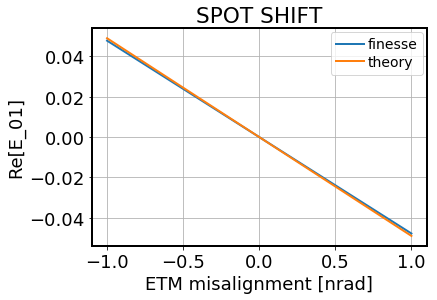

In [17]:
## check 00 mode back scatter
x=out.x
lam=1.064e-6
G_01=0.5 # 01 mode cav gain G_01 ~ 1/(1+r_itm*r_etm) ~ 1/2

# CLAIM: 00 phase shift is due to a2l backscattering

# order of mag estimation of 00 mode phase shift
# misalign -> mis-centering
d_theta=out.x
d_pos = d_theta * 1.e4 # round trip arm lengh ~10km = 1E+4 m
E_01_re_exp = np.real(E_00_cav[5]) * d_pos/WAIST # 01 mode due to spot shift
E_01_re_exp *= G_01 # account for cavity filtering

plt.plot(x*1.e9, np.real(E_01_cav), label='finesse')
plt.plot(x*1.e9, E_01_re_exp, label='theory')
plt.legend()
plt.xlabel('ETM misalignment [nrad]')
plt.ylabel('Re[E_01]')
plt.title('SPOT SHIFT')


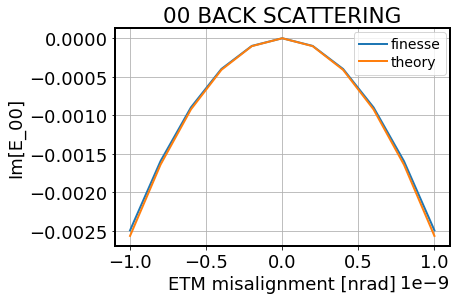

In [20]:
T_itm=0.014
G_00 = 2./T_itm # when 01 back scatters to 00, the 00 is amplified by the cav b.c. it's resonant
E_00_back=np.real(E_01_re_exp) * 2j * d_theta * np.pi * SPOT / lam
E_00_back*=G_00
plt.plot(x, np.imag(E_00_cav), label='finesse')
plt.plot(x, np.imag(E_00_back), label='theory')
plt.legend()
plt.xlabel('ETM misalignment [nrad]')
plt.ylabel('Im[E_00]')
plt.title('00 BACK SCATTERING')

In [25]:
Latex(r"""
\begin{align}
&CONCLUSION\ II:\\
&\textrm{For a mirror inside the cavity, the phase shift on 00 mode is due to a2l effects.}\\
&\textrm{I.e.: 00 input first scatter to 01 mode (imaginary; tilt)}, \\
&\textrm{the 01 mode goes around the cavity and becomes shift (real)}\\
&\textrm{then once again scatters into 00 imaginary and thus causing a phase shift} \\

&\frac{\Im[E_{00}]^{\rm (back)}}{E_{00}} = G_{00}G_{01}\left(\frac{2\pi w}{\lambda}\right)\left(\frac{G_{\rm t2s}\Delta \theta}{w_0}\right), \\
&\textrm{where,}\\
&G_{00}\sim\frac{1}{1-r_{\rm itm}r_{\rm etm}}, \textrm{the 00 cavity gain}, \\
&G_{01}\sim\frac{1}{1+r_{\rm itm}r_{\rm etm}}, \textrm{the 01 cavity gain}, \\
&G_{\rm t2s}\sim 2L_{\rm cav}, \textrm{the tilt (in rad) to shift (in m) conversion},\\
&w \textrm{the spot size, } w_0 \textrm{the waist.}
\end{align}
i.e., everything is as expected.
""")

<IPython.core.display.Latex object>

In [3]:
"""
task 3: shall we compensate for it?

In other word, does the phase change in 00 mode
caused by a2l equivalent to a physical length variation?
"""
lam=1.064e-6
c=const.c
f0=c/lam

ddeg_dm_detune = (180./np.pi) * 2.* np.pi * f0 / c 
# converting length detuning in [m] to [deg]


## first calculate how much length change does a2l induce.
## order of magnitude : 
## for 1nrad misalignment, delta L =delta d x delta theta = (1e+4 * 1e-9) * 1e-9 = 1e-14
## so dm_drad_a2l ~ 1e-5 [m/rad]

# length
kat=finesse.kat()
kat.loadKatFile('misalignMirror.kat')
kat.verbose=False

cmd="""
    ad E_pd_ac 0 0 0 n_bs4
    
    xaxis ETMHR phi lin -1n 1n 10
    put ETMAR phi $x1
    yaxis re:im
    """
kat.parseCommands(cmd)
out=kat.run()
E_pd_ac=out['E_pd_ac']
x=out.x

dE_ddeg = np.imag(E_pd_ac[-1] - E_pd_ac[0])/(x[-1]-x[0])

# angle
kat=finesse.kat()
kat.loadKatFile('misalignMirror.kat')
kat.verbose=False

cmd="""
    ad E_pd_ac 0 0 0 n_bs4
    
    xaxis ETMHR ybeta lin 0 1n 10
    put ETMAR ybeta $x1
    yaxis re:im
    """
kat.parseCommands(cmd)
out=kat.run()
E_pd_ac=out['E_pd_ac']
x=out.x

dE_drad = np.imag(E_pd_ac[-1] - E_pd_ac[0])/(x[-1]-x[0])

dm_drad_a2l = dE_drad / dE_ddeg /ddeg_dm_detune
print(dm_drad_a2l)

1.25722928761e-05


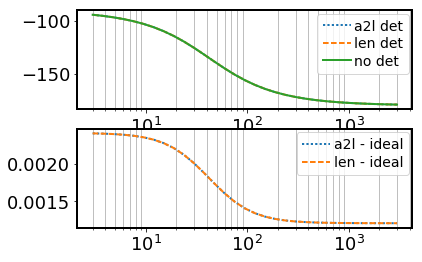

In [10]:
# now check if the two are equivalent
# by computing the cavity tf
# no dc detuning, ac field should be pure phase change for f_ac << cav pole ~ 44 Hz
# if dc detuned in length, deviating from pure phase shift
# does a2l create the same detuning effect?

kat=finesse.kat()
kat.loadKatFile('misalignMirror.kat')
kat.verbose=False

cmd="""
    ad E_pd_ac 0 0 0 n_bs4
    
    fsig sigE ETMHR phase 10 0 1n 
    fsig sigE_AR ETMAR phase 10 0 1n
    
    xaxis sigE f log 3 3k 30
    put E_pd_ac f $x1
    yaxis re:im
    """
kat.parseCommands(cmd)

E_pd_ac=np.zeros([3, 31], dtype=np.complex)
for i in range(3):
    kat_loop=kat.deepcopy()
    if i==1:
        kat_loop.ETMHR.ybeta = 1.e-9
        kat_loop.ETMAR.ybeta = 1.e-9
    if i==2:
        kat_loop.ETMHR.phi = 1.e-9 * dm_drad_a2l * ddeg_dm_detune
        kat_loop.ETMAR.phi = 1.e-9 * dm_drad_a2l * ddeg_dm_detune
        
    out=kat_loop.run()
    E_pd_ac[i, :]=out['E_pd_ac']

x=out.x
    
fig=plt.figure()
ax=fig.add_subplot(211)
ax.semilogx(x, np.angle(E_pd_ac[1, :], deg=True), ls=':', label='a2l det')
ax.semilogx(x, np.angle(E_pd_ac[2, :], deg=True), ls='--', label='len det')
ax.semilogx(x, np.angle(E_pd_ac[0, :], deg=True), label='no det')
ax.grid(which='both')
ax.legend()

ax=fig.add_subplot(212)
ax.semilogx(x, np.angle(E_pd_ac[1, :], deg=True) - np.angle(E_pd_ac[0, :], deg=True), ls=':', label='a2l - ideal')
ax.semilogx(x, np.angle(E_pd_ac[2, :], deg=True) - np.angle(E_pd_ac[0, :], deg=True), ls='--', label='len - ideal')
ax.grid(which='both')
ax.legend()
